In [12]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [180]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = {
    # xticks
    "xtick.top": False,
    "xtick.direction": "out",
    "xtick.major.size": 5,
    "xtick.minor.visible": False,
    # yticks
    "ytick.right": False,
    "ytick.direction": "out",
    "ytick.major.size": 5,
    "ytick.minor.visible": False,
    # pallete
    "axes.prop_cycle": mpl.cycler(
        color=[
            "#fdbf6f",  # Yellow
            "#ff7f00",  # Orange
            "#a6cee3",  # Cyan
            "#1f78b4",  # Blue
            "violet",
            "#956cb4",  # Purple
            "mediumaquamarine",
            "#029e73",  # Green
            "#c44e52",  # Red
        ]
    ),
}
plt.rcParams.update(params)

<IPython.core.display.Javascript object>

## Load

In [35]:
base_dir = "data/retrievals/spot_upper_bound"

########
# Models
########
fpaths_dict = {
    "Na+K+TiO (clear)": f"{base_dir}/HATP23_E1_NoHet_FitP0_NoClouds_NoHaze_fitR0_Na_K_TiO",
    "Na+K+TiO (haze)": f"{base_dir}/HATP23_E1_NoHet_FitP0_NoClouds_Haze_fitR0_Na_K_TiO",
    "Na+K+TiO (spot)": f"{base_dir}/HATP23_E1_Het_FitP0_NoClouds_NoHaze_fitR0_Na_K_TiO",
    "Na+K+TiO (spot+haze)": f"{base_dir}/HATP23_E1_Het_FitP0_NoClouds_Haze_fitR0_Na_K_TiO",
}
fpaths_dict

{'Na+K+TiO (clear)': 'data/retrievals/spot_upper_bound/HATP23_E1_NoHet_FitP0_NoClouds_NoHaze_fitR0_Na_K_TiO',
 'Na+K+TiO (haze)': 'data/retrievals/spot_upper_bound/HATP23_E1_NoHet_FitP0_NoClouds_Haze_fitR0_Na_K_TiO',
 'Na+K+TiO (spot)': 'data/retrievals/spot_upper_bound/HATP23_E1_Het_FitP0_NoClouds_NoHaze_fitR0_Na_K_TiO',
 'Na+K+TiO (spot+haze)': 'data/retrievals/spot_upper_bound/HATP23_E1_Het_FitP0_NoClouds_Haze_fitR0_Na_K_TiO'}

<IPython.core.display.Javascript object>

In [38]:
# Load
data_dict = {
    model_name: {
        "data": ascii.read(f"{model_dir}/retr_model.txt"),
        "sampled_data": ascii.read(
            f"{model_dir}/retr_model_sampled_Magellan_IMACS.txt"
        ),
    }
    for (model_name, model_dir) in fpaths_dict.items()
}

instrument_dict = {
    "Magellan_IMACS": {
        "plot_kwargs": {
            "c": "w",
            "mec": "k",
            "fmt": "o",
            "ecolor": "k",
            "label": "Magellan/IMACS",
            "zorder": 10,
        },
        "data": ascii.read(f"{base_dir}/instruments/retr_Magellan_IMACS.txt"),
    }
}

<IPython.core.display.Javascript object>

## Plot

In [39]:
fig, ax = plt.subplots(figsize=FIG_WIDE)

for (model_name, model_dict) in data_dict.items():
    # Plot model
    p = utils.plot_model(
        ax,
        model_dict,
        model_kwargs={"label": model_name},
        fill_kwargs={"alpha": 0.25},
        sample_kwargs={"marker": "o"},
    )

#############
# Instruments
#############
for (instrument_name, instrument_data) in instrument_dict.items():
    instrument_name = instrument_name.replace("_", "/")
    utils.plot_instrument(ax, instrument_data)

####################
# Annotate Delta lnZ
####################
# fpath = f"{models[model_key_name]}/retrieval.pkl"
# fpath_flat = f'{models["K (clear)"]}/retrieval.pkl'
# DlnZ, DlnZ_unc, lnZ, lnZ_unc = utils.get_Delta_lnZ(fpath, fpath_flat)
# s = f"$\Delta \ln(Z) = {DlnZ:.2f} \pm {DlnZ_unc:.2f}$"
# ax.annotate(s, (0.02, 0.05), xycoords="axes fraction")

"""
# Plot inset
axins = ax.inset_axes([0.5, 0.5, 0.5, 0.5])
# Shortcut to zoom in on last instrument
p = plot_instrument(axins, instr, instr_sampled, instr_kwargs=configs, sampled_kwargs=sampled_kwargs)
axins.set_xlim(p.get_xlim())
axins.set_ylim(p.get_ylim())
plot_model(axins, model, model_kwargs=model_kwargs, fill_kwargs=fill_kwargs)
ax.indicate_inset_zoom(axins, alpha=1.0, edgecolor='w')
"""

ax.set_xlim(0.5, 0.95)
ax.set_ylim(12_400, 14_500)
ax.set_xlabel(r"Wavelength $(\mu\mathrm{m})$")
ax.set_ylabel("Transit depth (ppm)")
ax.legend(loc=1, ncol=3, fontsize=14)

#########
# Species
#########
species = {
    "Na I-D": 5892.9,
    #'Hα':6564.6,
    "K I_avg": 7682.0,
    "Na I-8200_avg": 8189.0,
}
[
    ax.axvline(wav / 10000, lw=0.5, ls="--", color="grey", zorder=0)
    for name, wav in species.items()
]

# ax.annotate(f"Python 2", (0.05, 0.9), xycoords='axes fraction')

# plt.savefig('/Users/mango/Desktop/exoretrievals_py2.png', dpi=250, bbox_inches='tight')

fig.set_size_inches(FIG_WIDE)
# fig.tight_layout()
# utils.savefig('projects/HATP23b/paper/figures/retrievals/retrieval.pdf')
# plt.savefig(f"/Users/mango/Desktop/tspec_haze_mid.pdf", bbox_inches="tight")
# plt.savefig(f'../retrieval/kreidberg/{species}/tspec/retr_{basename}.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>

## Corner plot

In [41]:
fpath = "data/retrievals/spot_lower_bound/HATP23_E1_Het_FitP0_NoClouds_NoHaze_fitR0_Na_K_TiO/retrieval.pkl"
post = utils.load_pickle(fpath)

df = pd.DataFrame(post["samples"])

params = {
    "logP0": r"$\log P_0$",
    "T": r"$T_\mathrm{p}$",
    #     'logH2O':r'$\log \mathrm{H}_2\mathrm{O}$',
    "logNa": r"$\log \mathrm{Na}$",
    "logK": r"$\log \mathrm{K}$",
    "logTiO": r"$\log \mathrm{TiO}$",
    "f": r"$f$",
}

if "_Haze" in fpath:
    params["loga"] = r"$\log a$"
    params["gamma"] = r"$\gamma_\mathrm{haze}$"

if "_Het" in fpath:
    params["Tocc"] = r"$T_\mathrm{star}$"
    # params["Thet"] = r"$T_\mathrm{het}$"
    # params["Fhet"] = r"$f_\mathrm{het}$"

df_params = df[params.keys()]

corner_kwargs = {"show_titles": True}
hist_kwargs = {"histtype": "stepfilled", "lw": 2, "density": True}
fig, axes = utils.plot_corner(
    df_params,  # .drop(["Thet", "Fhet"], axis=1),
    params=params,
    c=f"C5",
    corner_kwargs=corner_kwargs,
    hist_kwargs=hist_kwargs,
)

fig.set_size_inches(18, 18)

# utils.savefig('projects/HATP23b/paper/figures/retrievals/retrieval_corner.pdf')
# plt.savefig(f'../retrieval/kreidberg/{species}/corner/corner_{basename}.pdf', bbox_inches='tight')
# plt.savefig(f'/Users/mango/Desktop/corner_{source}_all.pdf', bbox_inches='tight')
# plt.savefig(f"/Users/mango/Desktop/corner_test.pdf", bbox_inches="tight")

<IPython.core.display.Javascript object>

## Evidences

In [11]:
# add clear+cloud+haze

base_dir = "../../ACCESS.jl/src/data_retrievals/spot_lower_fixed_R0"
fit_R0 = "fitR0" if "fit_R0" in base_dir else "NofitR0"

<IPython.core.display.Javascript object>

In [116]:
species = ["Na", "K", "TiO", "Na_K", "Na_TiO", "K_TiO", "Na_K_TiO"]
model_names_dict = {
    "clear": f"NoHet_FitP0_NoClouds_NoHaze_{fit_R0}",
    "clear+cloud": f"NoHet_FitP0_Clouds_NoHaze_{fit_R0}",
    "clear+haze": f"NoHet_FitP0_NoClouds_Haze_{fit_R0}",
    "clear+spot": f"Het_FitP0_NoClouds_NoHaze_{fit_R0}",
    "clear+spot+cloud": f"Het_FitP0_Clouds_NoHaze_{fit_R0}",
    "clear+spot+haze": f"Het_FitP0_NoClouds_Haze_{fit_R0}",
    "clear+spot+cloud+haze": f"Het_FitP0_Clouds_Haze_{fit_R0}",
}

<IPython.core.display.Javascript object>

In [117]:
len(np.unique(list(model_names_dict.values())))

7

<IPython.core.display.Javascript object>

In [118]:
# Load
data_dict = {
    sp: {
        model_name: utils.load_pickle(
            f"{base_dir}/HATP23_E1_{model_id}_{sp}/retrieval.pkl"
        )
        for (model_name, model_id) in model_names_dict.items()
    }
    for sp in species
}

<IPython.core.display.Javascript object>

In [40]:
data_dict["Na"]["clear"].keys()

dict_keys(['lnZ', 'lnZerr', 'unnamed_samples', 'samples'])

<IPython.core.display.Javascript object>

K clear


,Na,K,TiO,Na_K,Na_TiO,K_TiO,Na_K_TiO
clear,4.228008,0.000000,6.470431,3.961596,5.965399,5.906551,5.620903
clear+cloud,3.631123,1.485933,5.398483,3.179458,5.170945,4.996205,4.870079
clear+haze,3.684933,2.223177,5.362364,3.221512,5.124867,4.944949,4.720639
clear+spot,4.241980,3.812417,4.241815,3.685709,3.997720,3.751752,3.506001
clear+spot+cloud,3.174436,2.867850,3.291967,2.695057,3.033652,2.801135,2.538111
clear+spot+haze,3.034682,2.817973,3.120746,2.614493,2.828451,2.655219,2.427965
clear+spot+cloud+haze,2.159865,1.938158,2.208348,1.660904,1.910795,1.798888,1.529130


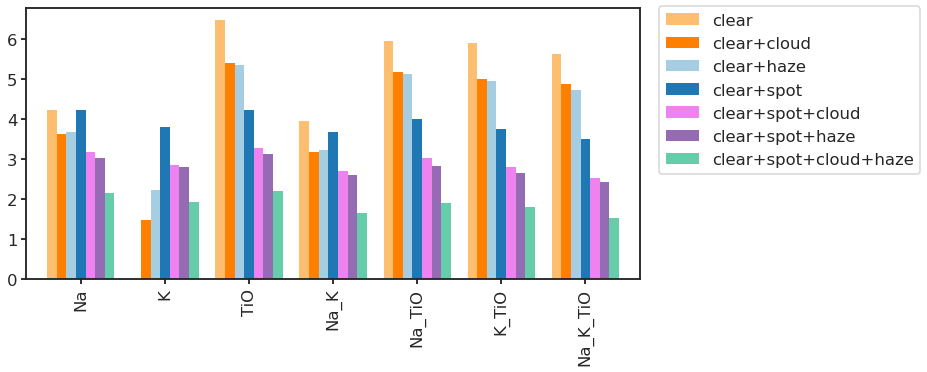

<IPython.core.display.Javascript object>

In [185]:
lnZ = {}
for species_name, species_data in data_dict.items():
    lnZ[species_name] = {}
    for model_name, model_data in species_data.items():
        lnZ[species_name][model_name] = model_data["lnZ"]  # , model_data["lnZerr"]

df_lnZ = pd.DataFrame(lnZ)

species_min = df_lnZ.min().idxmin()
model_min = df_lnZ[species_min].idxmin()
print(species_min, model_min)

df_flat = data_dict[species_min][model_min]

df_Delta_lnZ = df_lnZ - df_flat["lnZ"]

display(df_Delta_lnZ)

fig, ax = plt.subplots(figsize=FIG_WIDE)

p = df_Delta_lnZ.transpose().plot(ax=ax, kind="bar", width=0.8, lw=0)

p.legend(loc="upper right", bbox_to_anchor=(1.47, 1.035))